In [94]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
import matplotlib.image as mpimg
from sklearn.feature_selection import SelectKBest, chi2
from moviepy.editor import VideoFileClip

%matplotlib inline
pix_per_cell = 8
cell_per_block = 2
orient = 9
channel_size = (16, 16)
nbins = 8
img = cv2.imread("vehicles/GTI_Far/image0000.png")

def color_hist(img, nbins=nbins, bins_range=(0, 256)):
    # Return the individual histograms, bin_centers and feature vector
    return np.histogram(img, bins=nbins, range=bins_range)[0]

def extract_features(img_section):
    img_section = cv2.resize(img_section, channel_size)
    HLS = cv2.cvtColor(img_section, cv2.COLOR_BGR2HLS)
    hist_1 = color_hist(HLS[:,:,1])
    hist_2 = color_hist(HLS[:,:,2])
    LAB = cv2.cvtColor(img_section, cv2.COLOR_BGR2LAB)
    hist_3 = color_hist(LAB[:,:,1])
    hog_features_1 = hog(HLS[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), feature_vector=True)
    hog_features_2 = hog(HLS[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), feature_vector=True)
    hog_features_3 = hog(LAB[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), feature_vector=True)
    features = [hog_features_1.ravel(),
                hog_features_2.ravel(),
                hog_features_3.ravel(),
               hist_1,
               hist_2,
               hist_3,
               HLS[:,:,1].ravel(),
               HLS[:,:,2].ravel(),
               LAB[:,:,1].ravel()]
    return np.hstack(features).astype(np.float64)


#interesting features:
# HLS - L + S
# LAB - A

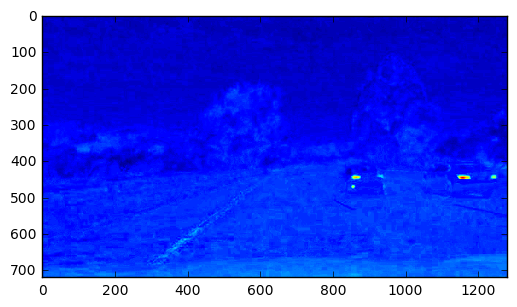

In [110]:
img = cv2.imread('test_images/test4.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,1])

In [95]:
import glob
from tqdm import tqdm
images = glob.glob("non-vehicles/*/*.png")
non_vehicles = []
for fname in tqdm(images):
    image = cv2.imread(fname)
    non_vehicles.append(extract_features(image))
non_vehicles = np.array(non_vehicles)
print("done non vehicles")

images = glob.glob("vehicles/*/*.png")
vehicles = []
for fname in tqdm(images):
    image = cv2.imread(fname)
    vehicles.append(extract_features(image))
vehicles = np.array(vehicles)


  0%|          | 0/8792 [00:00<?, ?it/s]

done non vehicles



100%|██████████| 8792/8792 [01:07<00:00, 129.64it/s]

In [96]:
X = np.vstack([non_vehicles, vehicles])
y = np.hstack([np.zeros(len(non_vehicles)), np.ones(len(vehicles))])

In [97]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [98]:
selector = SelectKBest(k="all")
selector.fit(X_train, y_train)
significant_features = 0
for val in selector.pvalues_:
    if val < 0.05:
        significant_features += 1
selector = SelectKBest(k=significant_features)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [99]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#clf = SVC(kernel="rbf", C=0.4, class_weight="balanced")
clf = RandomForestClassifier(max_features=None, n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
#X_test = selector.transform(X_test)
predictions = clf.predict(X_test)
print(f1_score(predictions, y_test))
#RF - 0.9815
#0.95212

0.97642481117


In [101]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
img = cv2.imread('test_images/test4.jpg')

def generate_heatmap(img):
    windows = []
    windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                         xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                        xy_window=(48, 48), xy_overlap=(0.5, 0.5))
#     windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
#                         xy_window=(32, 32), xy_overlap=(0.5, 0.5))
#     windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
#                         xy_window=(24, 24), xy_overlap=(0.5, 0.5))
    heatmap = np.zeros(img.shape)
    total = np.zeros(img.shape)
    for window in windows:
        section = img[window[0][1]:window[1][1], window[0][0]: window[1][0]]
        features = extract_features(section)
        features = scaler.transform(features.reshape(1, -1))
        features = selector.transform(features.reshape(1, -1))
        prediction = clf.predict_proba(features.reshape(1, -1))[0][1]
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += prediction
        total[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1

    heatmap = heatmap[:,:]/total[:,:]
    heatmap = np.nan_to_num(heatmap)
    return heatmap
#different areas are covered by the windows different numbers of times, account for this.
heatmap = generate_heatmap(img)

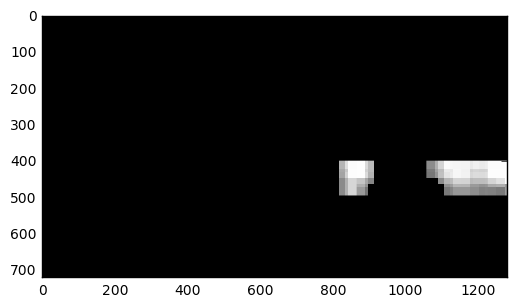

In [102]:
from scipy.ndimage.measurements import label
threshold = 0.45
heatmap[heatmap <= threshold] = 0
plt.imshow(heatmap)

In [103]:
def draw_labeled_bboxes(img, heatmap):
    labels = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

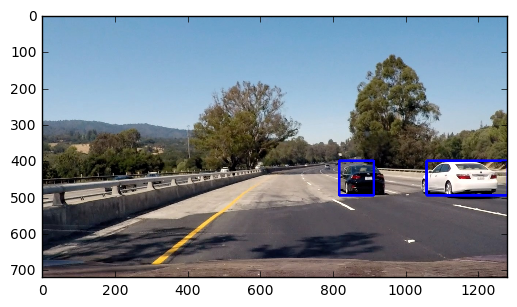

In [104]:
mat_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
to_draw = draw_labeled_bboxes(mat_img, heatmap)
plt.imshow(to_draw)

In [112]:
class Smoothing:
    heatmap = np.zeros(mat_img.shape)
    support = 0
    def update_support(self, heatmap, support):
        self.heatmap = (self.heatmap * self.support + heatmap * support)/(support+self.support)
        self.heatmap = np.nan_to_num(self.heatmap)
        self.support += support
        self.support /= 1.05
        return np.copy(self.heatmap)
smoother = Smoothing()

In [113]:
def fully_process_image(img):
    heatmap = generate_heatmap(img)
    support = np.sum(heatmap[heatmap >= .45])
    heatmap = smoother.update_support(heatmap, support)
    heatmap[heatmap < .45] = 0
    drawn = draw_labeled_bboxes(img, heatmap)
    return drawn
video = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(fully_process_image)
white_clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [2:55:38<00:08,  8.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

